# Fornax Cloud Access Demo

This notebook illustrates the cloud access tools developed as part of the Fornax project.

It uses `pyvo`, a python client that uses the Virtual Observatory protocols to find data, then it uses the code from the `fornax` library to download data from the cloud. These features are illustrated by finding data for the galaxy M82 from HST, Galex, Chandra and Spitzer and downloading it from AWS.


---
## 1. Introduction
- The platform has a wide range pre-installed software. 

- Users will also be able to install other tools (e.g. using `pip install ...` for python).

- In this example, we call functions in `demo_helpers` to install some libraries that enable our `fornax` module to run.

- Next, we define a sky position that we will use throught the notebook.


#### Import the `fornax` module

In [1]:
from demo_helpers import *
import fornax

#### Define some sky position

In [2]:
pos = coord.SkyCoord.from_name("M82")

---
## 2. Discovery of Cloud Data
- Data in the cloud is discovered though the archive discovery and search tools that use the VO standards.
- For example: a request to MAST services for 'GALEX Images of M82' will return new information of where in the cloud the data is stored.
- Because we use VO standards. All VO clients can find this information.

In [3]:
# Search Galex Image service
galex_service = pyvo.regsearch(keywords=['galex'], servicetype='image')[0]
query_result = galex_service.search(pos=(pos.ra.deg, pos.dec.deg), size=10*u.arcsec)
galex_result = filter_galex_results(query_result)
print(f'The query returned {len(query_result)} entries')

The query returned 1685 entries


- The service returns information about how to access the data from on-prem servers as well as the cloud

In [4]:
galex_result[['accessURL', 'cloud_access']]

accessURL,cloud_access
object,object
https://mast.stsci.edu/api/v0.1/Download/file?uri=mast:GALEX/url/data/GR6/pipe/01-vsn/05583-NGA_M82/d/01-main/0001-img/07-try/qa/NGA_M82-xd-int_2color_large.jpg,"{""aws"": {""bucket_name"":""stpubdata"",""region"":""us-east-1"",""access"":""open"",""key"":""galex/GR6/pipe/01-vsn/05583-NGA_M82/d/01-main/0001-img/07-try/qa/NGA_M82-xd-int_2color_large.jpg""}}"
https://mast.stsci.edu/api/v0.1/Download/file?uri=mast:GALEX/url/data/GR6/pipe/01-vsn/05583-NGA_M82/d/01-main/0001-img/07-try/qa/NGA_M82-xd-int_2color_large.jpg,"{""aws"": {""bucket_name"":""stpubdata"",""region"":""us-east-1"",""access"":""open"",""key"":""galex/GR6/pipe/01-vsn/05583-NGA_M82/d/01-main/0001-img/07-try/qa/NGA_M82-xd-int_2color_large.jpg""}}"
https://mast.stsci.edu/api/v0.1/Download/file?uri=mast:GALEX/url/data/GR6/pipe/01-vsn/05583-NGA_M82/d/00-visits/0001-img/07-try/qa/NGA_M82_0001-xd-int_2color_large.jpg,"{""aws"": {""bucket_name"":""stpubdata"",""region"":""us-east-1"",""access"":""open"",""key"":""galex/GR6/pipe/01-vsn/05583-NGA_M82/d/00-visits/0001-img/07-try/qa/NGA_M82_0001-xd-int_2color_large.jpg""}}"
https://mast.stsci.edu/api/v0.1/Download/file?uri=mast:GALEX/url/data/GR6/pipe/01-vsn/05583-NGA_M82/d/00-visits/0001-img/07-try/qa/NGA_M82_0001-xd-int_2color_large.jpg,"{""aws"": {""bucket_name"":""stpubdata"",""region"":""us-east-1"",""access"":""open"",""key"":""galex/GR6/pipe/01-vsn/05583-NGA_M82/d/00-visits/0001-img/07-try/qa/NGA_M82_0001-xd-int_2color_large.jpg""}}"
https://mast.stsci.edu/api/v0.1/Download/file?uri=mast:GALEX/url/data/GR6/pipe/01-vsn/05583-NGA_M82/d/00-visits/0002-img/07-try/qa/NGA_M82_0002-xd-int_2color_large.jpg,"{""aws"": {""bucket_name"":""stpubdata"",""region"":""us-east-1"",""access"":""open"",""key"":""galex/GR6/pipe/01-vsn/05583-NGA_M82/d/00-visits/0002-img/07-try/qa/NGA_M82_0002-xd-int_2color_large.jpg""}}"
https://mast.stsci.edu/api/v0.1/Download/file?uri=mast:GALEX/url/data/GR6/pipe/01-vsn/05583-NGA_M82/d/00-visits/0002-img/07-try/qa/NGA_M82_0002-xd-int_2color_large.jpg,"{""aws"": {""bucket_name"":""stpubdata"",""region"":""us-east-1"",""access"":""open"",""key"":""galex/GR6/pipe/01-vsn/05583-NGA_M82/d/00-visits/0002-img/07-try/qa/NGA_M82_0002-xd-int_2color_large.jpg""}}"
https://mast.stsci.edu/api/v0.1/Download/file?uri=mast:GALEX/url/data/GR6/pipe/01-vsn/05583-NGA_M82/d/00-visits/0003-img/07-try/qa/NGA_M82_0003-xd-int_2color_large.jpg,"{""aws"": {""bucket_name"":""stpubdata"",""region"":""us-east-1"",""access"":""open"",""key"":""galex/GR6/pipe/01-vsn/05583-NGA_M82/d/00-visits/0003-img/07-try/qa/NGA_M82_0003-xd-int_2color_large.jpg""}}"
https://mast.stsci.edu/api/v0.1/Download/file?uri=mast:GALEX/url/data/GR6/pipe/01-vsn/05583-NGA_M82/d/00-visits/0003-img/07-try/qa/NGA_M82_0003-xd-int_2color_large.jpg,"{""aws"": {""bucket_name"":""stpubdata"",""region"":""us-east-1"",""access"":""open"",""key"":""galex/GR6/pipe/01-vsn/05583-NGA_M82/d/00-visits/0003-img/07-try/qa/NGA_M82_0003-xd-int_2color_large.jpg""}}"
https://mast.stsci.edu/api/v0.1/Download/file?uri=mast:GALEX/url/data/GR6/pipe/01-vsn/05583-NGA_M82/d/00-visits/0004-img/07-try/qa/NGA_M82_0004-xd-int_2color_large.jpg,"{""aws"": {""bucket_name"":""stpubdata"",""region"":""us-east-1"",""access"":""open"",""key"":""galex/GR6/pipe/01-vsn/05583-NGA_M82/d/00-visits/0004-img/07-try/qa/NGA_M82_0004-xd-int_2color_large.jpg""}}"


---
## 3. Accessing & Downloading Cloud Data
- Once data is discoverd, we provide the tools that allow the user to select and download the data from the cloud

In [5]:
# For the search query above
print(galex_result[0]['cloud_access'], '\n')

galex_aws = fornax.get_data_product2(galex_result[1], 'aws')
galex_file = galex_aws.download()

print(f'\nThe Downloaded file is: {galex_file}')

{"aws": {"bucket_name":"stpubdata","region":"us-east-1","access":"open","key":"galex/GR6/pipe/01-vsn/05583-NGA_M82/d/01-main/0001-img/07-try/qa/NGA_M82-xd-int_2color_large.jpg"}} 


The Downloaded file is: NGA_M82-xd-int_2color_large.jpg


- Now we can display it

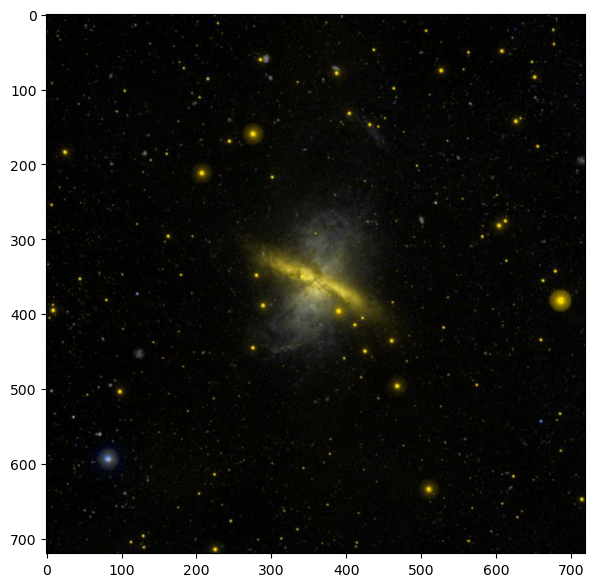

In [6]:
fig = plt.figure(figsize=(7,7))
plt.imshow(plt.imread(galex_file)[600:-600,600:-600])


### 3.1 Examples From The Three Archives
- Here we show examples of finding and downloading data from the three archives.
- First, the archives services are queried to find the data
- Then, we select to download it from the on-prem or the cloud

#### A. HST data from prem (MAST):

In [7]:
hst_url = galex_service.access_url.replace('GALEX', 'HST')
hst_service = pyvo.dal.sia.SIAService(hst_url)
query_result = hst_service.search(pos=(pos.ra.deg, pos.dec.deg), size=10*u.arcsec)
hst_result = filter_hst_results(query_result)
print(f'The query returned {len(query_result)} entries')

The query returned 2424 entries


In [ ]:
hst_prem = fornax.get_data_product2(hst_result[-4], 'prem')
hst_file = hst_prem.download()
print(f'\nThe Downloaded file is: {hst_file}')

In [ ]:
# display the HST image
fig = plt.figure(figsize=(7,7))
plt.imshow(plt.imread(hst_file)[20:-20,20:-20])

#### B. Chandra data from AWS (HEASARC):

In [ ]:
# Query data provider 
chandra_url = 'https://heasarc.gsfc.nasa.gov/xamin_aws/vo/sia?table=chanmaster'
chandra_service = pyvo.dal.sia.SIAService(chandra_url)
query_result = chandra_service.search(pos=(pos.ra.deg, pos.dec.deg), size=10*u.arcsec)
print(f'The query returned {len(query_result)} entries')

In [ ]:
chandra_aws = fornax.get_data_product2(query_result[-5], 'aws', 'ucd')
chandra_file = chandra_aws.download()

print(f'\nThe Downloaded file is: {chandra_file}')

In [ ]:
# Display Chandra image
fig = plt.figure(figsize=(7,7))
plt.imshow(plt.imread(chandra_file)[600:-50,300:-300])

#### C. Spitzer Data from AWS (IRSA):

In [ ]:
spizter_url = 'https://irsa.ipac.caltech.edu/SIA'
spizter_service = pyvo.dal.sia2.SIAService(spizter_url)
query_result = spizter_service.search(pos=(pos.ra.deg, pos.dec.deg, 10*u.arcsec),
                                      collection='spitzer_seip')
# get it in a table format
spitzer_result = query_result.to_table()
spitzer_result.sort('access_url')


print(f'The query returned {len(query_result)} entries')

In [ ]:
t0 = time.time()
spitzer_aws = fornax.get_data_product2(spitzer_result[4], 'aws')
spitzer_file = spitzer_aws.download()

print(f'\nThe Downloaded file is: {spitzer_file}')
print(f'It took {time.time() - t0:.3} seconds')

In [ ]:
# Display Spitzer Data
fig = plt.figure(figsize=(7,7))
with fits.open(spitzer_file) as fp:
    plt.imshow(fp[0].data[2500:3360,1800:2730], norm='symlog')

---
## 4. Cutout From Cloud
- In the previous examples, we had to download the whole image files and then plot a small cutout of the galaxy.
- This can be slow for large files.
- The following is an example of how a cutout can be done for part of the image that is stored in the cloud, applied to the Spitzer image.

In [ ]:
# First, we obtain a cloud link to the image
s3_uri = spitzer_aws.get_links()[0]
print(s3_uri)

In [ ]:
# we do the cutout
t0 = time.time()
with fits.open(s3_uri, fsspec_kwargs={"anon": True}) as hdul:  
    cutout = hdul[0].section[2500:3360,1800:2730]
print(f'Cutout time {time.time() - t0:.3} seconds')

In [ ]:
# then we display it
fig = plt.figure(figsize=(7,7))
plt.imshow(cutout, norm='symlog')

---
## 5. Display All The Images Together

In [ ]:
fig,axs = plt.subplots(1,4,figsize=(14,4))

axs[0].imshow(plt.imread(hst_file)[20:-20,20:-20])
axs[0].set_title('HST')

axs[1].imshow(plt.imread(galex_file)[820:-820,800:-800])
axs[1].set_title('Galex')

axs[2].imshow(plt.imread(chandra_file)[600:-50,300:-300])
axs[2].set_title('Chandra')

with fits.open(spitzer_file) as fp:
    axs[3].imshow(fp[0].data[2500:3360,1800:2730], norm='symlog')
axs[3].set_title('Spitzer')